# qnlp-tutorial

We go through the basics of DisCoPy and QNLP. On the menu:

1. [Drawing cooking recipes](#1.-Drawing-cooking-recipes)
2. [Tensors as boxes](#2.-Tensors-as-boxes)
3. [Drawing quantum circuits](#3.-Drawing-quantum-circuits)
4. [Drawing grammatical structure](#4.-Drawing-grammatical-structure)
5. [Putting it all together: QNLP](#5.-Putting-it-all-together:-QNLP)
6. [References](#References)

In [1]:
import numpy as np
from discopy import Ob, Ty, Box, drawing, Id, Swap, Diagram, Functor, Dim, Tensor, Cup, Cap, tensor, Word, pregroup
# from discopy.quantum import qubit, H, Id, CX, QuantumGate, Ket, Bra, Measure, Discard, SWAP,  circuit, sqrt, X
# from pytket.extensions.qiskit import AerBackend, backends
# from pytket.extensions.qiskit.backends.ibm import job_monitor
# from pytket.extensions.qiskit.backends.ibm.IBMQ.ibmq import load_account

# Drawing grammatical structure

So far we've learnt how to draw diagrams of cooking recipes and how to evaluate quantum circuits. Now we're gonna see that diagrams can represent **grammatical structure**. The basic ingredients are grammatical types: `n` for noun, `s` for sentence, etc. Each ingredient has left and right adjoints `n.l` and `n.r` which represent a missing noun on the right and left respectively. For example, the type for intransitive verbs `n.r @ s` reads "take a noun on your left and give a sentence".

The cooking steps are of two kinds: words and cups. Words have no inputs, they output their own grammatical type. Cups have no outputs, they take as inputs two types `left` and `right` that cancel each other, i.e. such that `left.r == right`. The recipe for a sentence goes in three steps:

1. Tensor the word boxes together.
2. Compose with cups and identities.
3. Once there is only the sentence type `s` left, you parsed the sentence!

For example:

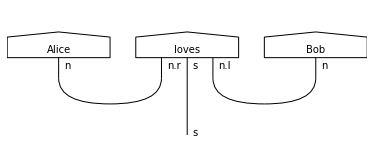

In [10]:
n, s = Ty('n'), Ty('s')

Alice = Word("Alice", n)
loves = Word("loves", n.r @ s @ n.l)
Bob = Word("Bob", n)

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

sentence = Alice @ loves @ Bob >> grammar
pregroup.draw(sentence, figsize=(5, 5))

Note that although in this tutorial we draw all our diagram by hand, this parsing process can be automated. Indeed once you fix a **dictionary**, i.e. a set of words with their possible grammatical types, it is completely mechanical to decide whether a sequence of words is grammatical. More precisely, it takes $O(n^3)$ time to decide whether a sequence of length $n$ is a sentence, and to output the diagram for its grammatical structure.

Such a dictionary is called a **pregroup grammar**, introduced by Lambek in 1999 and has been used to study the syntax of English, French, Persian and a dozen of other natural languages. Note that pregroup grammars are as expressive as the better known **context-free grammar**, where the diagrams are called **syntax trees**.

# Exercise 4.1
Draw the diagram of a sentence in a language with a different word order, e.g. Japanese.

we write the sentence Hanako ga tegami o kaita, which means Hanako has wrote a letter. 


ref : https://aclanthology.org/Y07-1009.pdf

![japan](imgs/japan.png)

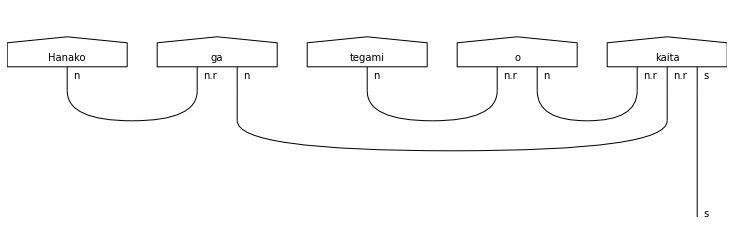

In [7]:
Hanako = Word("Hanako", n)
ga = Word("ga", n.r @ n)
tegami = Word("tegami", n)
o = Word("o", n.r @ n)
kaita = Word("kaita", n.r @ n.r @ s)

grammar_japanese = Cup(n, n.r) @ Id(n) @ Cup(n, n.r)  @ Cup(n, n.r)  @ Id(n.r) @ Id(s) >> Cup(n,n.r) @ Id(s)

sentence = Hanako @ ga @ tegami @ o @ kaita >> grammar_japanese
pregroup.draw(sentence, figsize=(10, 20))

## Exercise 4.2 
Draw the diagram of a sentence in a language written right to left, e.g. Arabic.

![arabic](imgs/arabicFlag.png)

ġadara ahmad al-madinah, which means ahmad left the city

ref https://www.researchgate.net/publication/326268380_Parsing_Arabic_Verb_Phrases_Using_Pregroup_Grammars

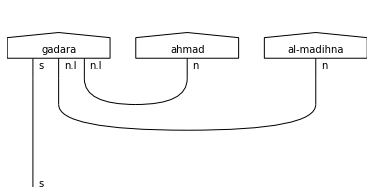

In [8]:
gadara = Word("gadara", s @ n.l @ n.l)
ahmad = Word("ahmad", n)
almadinah = Word("al-madihna", n)

grammar_arabic = Id(s) @ Id(n.l) @ Cup(n.l, n) @ Id(n) >> Id(s) @ Cup(n.l, n)

sentence = gadara @ ahmad @ almadinah >> grammar_arabic
pregroup.draw(sentence, figsize=(5, 10))

## Exercise 4.3 
Check out Lambek's [From word to sentence](https://www.math.mcgill.ca/barr/lambek/pdffiles/2008lambek.pdf), pick your favorite example and implement it in DisCoPy.

Implementing :  "I see you saw her"

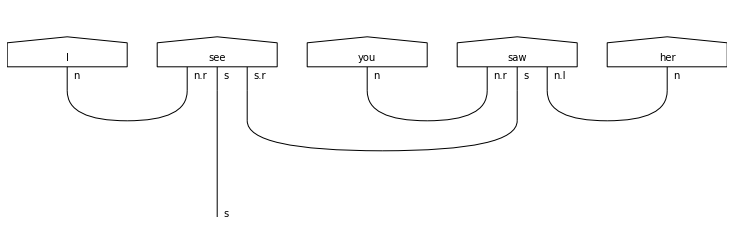

In [9]:
I = Word("I", n)
see = Word("see", n.r @ s @ s.r)
you = Word("you", n)
saw = Word("saw", n.r @ s @ n.l)
her = Word("her", n)

grammar_lambek = Cup(n,n.r) @ Id(s) @ Id(s.r) @ Cup(n, n.r) @ Id(s) @ Cup(n.l,n) >> Id(s) @ Cup(s.r, s)

sentence = I @ see @ you @ saw @ her >> grammar_lambek
pregroup.draw(sentence, figsize=(10, 20))

Now the main idea behind DisCoCat (categorical compositional distributional) models is to interpret each word as a vector and the grammatical structure as a linear map.
Composing the tensor of word vectors with the linear map for grammar yields the meaning of the sentence.
Another way to say this is in the language of **tensor networks**:
computing the meaning of a sentence corresponds to tensor contraction along the grammatical structure.

Yet another way to say the same thing is in the language of **category theory**: computing the meaning of a sentence corresponds to the evaluation of a (strong monoidal) functor from a pregroup grammar to the category of linear maps.
Maybe that last sentence puts you off, since category theory is also known as "generalised abstract nonsense". Don't worry, you don't need to remember pages of axioms to use DisCoPy, it keeps track of them for you.

Let's build a simple toy model where:

* we map `n` to `2`, i.e. we encode a noun as a 2d vector,
* we map `s` to `1`, i.e. we encode a sentence as a scalar,
* we map `Alice` and `Bob` to `[0, 1]` and `[1, 0]`, i.e. we encode them as the basis vectors,
* we map `loves` to the matrix `[[0, 1], [1, 0]]`, i.e. `Alice loves Bob` and `Bob loves Alice`.

In [11]:
F = tensor.Functor(
    ob={n: 2, s: 1},
    ar={Alice: [0, 1], loves: [0, 1, 1, 0], Bob: [1, 0]})

print(F(Alice @ loves @ Bob))
print(F(grammar))

assert F(Alice @ loves @ Bob >> grammar) == 1

Tensor(dom=Dim(1), cod=Dim(2, 2, 2, 2), array=[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
Tensor(dom=Dim(2, 2, 2, 2), cod=Dim(1), array=[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.])


Since `F(sentence) == 1`, we conclude that the sentence is true, i.e. Alice loves Bob!

If we evaluate the meaning of noun phrases rather than sentences, we get vectors that we can compare using inner products. This gives us a similarity measure between noun phrases. In our toy model, we can say that Alice and Bob are different: we defined their meaning to be orthogonal.

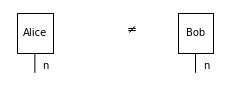

In [12]:
assert not F(Alice) >> F(Bob)[::-1]

drawing.equation(Alice, Bob, symbol="$\\neq$", figsize=(3, 1))

Let's define some more words:

* we map `man` to `[1, 0]`, i.e. Bob is the only man in our model,
* we map the adjective `rich` of type `n @ n.l` to the projector `[[1, 0], [0, 0]]`, i.e. only Bob is rich.

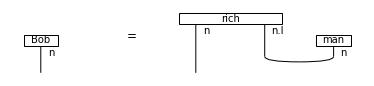

In [13]:
rich, man = Word("rich", n @ n.l), Word("man", n)

F.ar[rich], F.ar[man] = [1, 0, 0, 0], [1, 0]

rich_man = rich @ man >> Id(n) @ Cup(n.l, n)

assert F(Bob) >> F(rich_man)[::-1]  # i.e. Bob is a rich man.

drawing.equation(Bob, rich_man, figsize=(5, 1))

If we draw the diagram of a Who? question, the inner product with a noun phrase measures how well it answers the question.

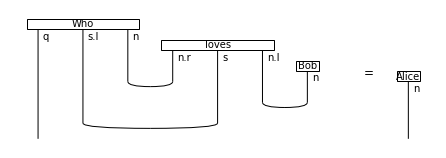

In [14]:
q = Ty('q')

Who = Word("Who", q @ s.l @ n)

F.ob[q], F.ar[Who] = 2, [1, 0, 0, 1]

question = Who @ loves @ Bob\
    >> Id(q @ s.l) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n)\
    >> Id(q) @ Cup(s.l, s) 

answer = Alice

assert F(question) == F(answer)

drawing.equation(question, answer, figsize=(6, 2))

## Exercise 4.4 
Draw your favorite sentence, define the meaning of each word then evaluate it as a tensor.

In [16]:
earth = Word("earth", n)
paper = Word("paper", n)
roundd = Word("round", n)
flat = Word("flat", n)
iss = Word("is", n.r @ s @ n.l)
isnot = Word("is not", n.r @ s @ n.l)

F = tensor.Functor(
    ob={n: 2, s: 1},
    ar={earth: [0, 1], roundd: [0, 1], paper: [1, 0], flat: [1, 0], isnot: [0, 1, 1, 0], iss: [1, 0, 0, 1]})

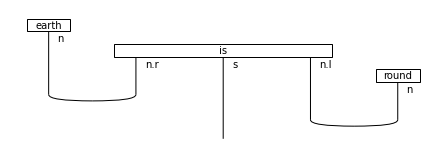

True


In [17]:
grammar = Cup(n,n.r) @ Id(s) @ Cup(n.l,n)
sentence = earth @ iss @ roundd >> grammar
sentence.draw(figsize=(6, 2))
print(f"{F(sentence).array[0]==1}")

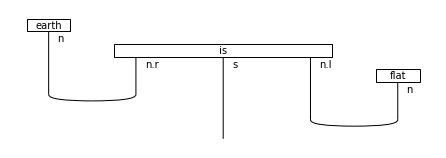

False


In [18]:
sentence = earth @ iss @ flat >> grammar
sentence.draw(figsize=(6, 2))
print(f"{F(sentence).array[0]==1}")

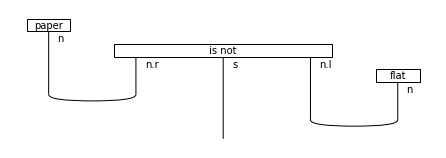

False


In [19]:
sentence = paper @ isnot @ flat >> grammar
sentence.draw(figsize=(6, 2))
print(f"{F(sentence).array[0]==1}")

## Exercise 4.5 
Build a toy model with a 4-dimensional noun space, add `Charlie` and `Diane` to the story.

<img src="imgs/midsummer.jpg" alt="drawing" width="200"/>

In [21]:
Alice = Word("Alice", n)
Bob = Word("Bob", n)
Charlie = Word("Charlie", n)
Diane = Word("Diane", n)
loves = Word("loves", n.r @ s @ n.l)
Who = Word("Who", q @ s.l @ n)

loves_mat = np.zeros((4,4))
loves_mat[0,1]=1
loves_mat[1,2]=1
loves_mat[2,3]=1
loves_mat[3,0]=1

F = tensor.Functor(
    ob={n: 4, s: 1, q :4},
    ar={Alice: [0, 0, 0, 1],
        Bob: [0, 0, 1, 0],
        Charlie: [0, 1, 0, 0],
        Diane: [1, 0, 0, 0],
        loves: loves_mat.flatten().tolist(),
        Who: loves_mat.flatten().tolist()})

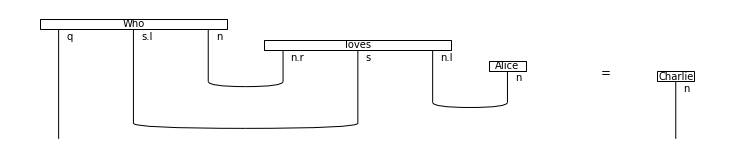

In [22]:
question = Who @ loves @ Alice\
    >> Id(q @ s.l) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n)\
    >> Id(q) @ Cup(s.l, s) 

F(question)

answer = Charlie

assert F(question) == F(answer)

drawing.equation(question, answer, figsize=(10, 2))

## Exercise 4.6 
Define the meaning of the word `Does` and draw the diagram for the yes-no question `Does Alice love Bob?`. The meaning of the question should be the same as the sentence `Alice loves Bob`, i.e. the answer is "yes" if the sentence is true.

In [ ]:
Does = Word("Does", s @ n.l @ s.l @ n.l)
# F.ar[Does] = [1, 0, 0, 1]

Does @ Alice @ loves @ Bob >> Id(s) @ Id(n.l) @ Id(s.l) @ Cup(n.l,n)  >> 

In [23]:
#TODO

## References

* Coecke, B., Sadrzadeh, M., & Clark, S. (2010) _Mathematical foundations for a compositional distributional model of meaning._ [arXiv:1003.4394](https://arxiv.org/abs/1003.4394)
* Zeng, W., & Coecke, B.  (2016) _Quantum algorithms for compositional natural language processing._ [arXiv:1608.01406](https://arxiv.org/abs/arXiv:1608.01406)
* de Felice, G., Toumi, A., & Coecke, B. (2020) _DisCoPy: Monoidal Categories in Python._ [arXiv:2005.02975](https://arxiv.org/abs/2005.02975)
* Meichanetzidis, K., Toumi, A., de Felice, G., & Coecke, B. (2020) _Grammar-Aware Question-Answering on Quantum Computers._ [arXiv:2012.03756](https://arxiv.org/abs/arXiv:2012.03756)
* Meichanetzidis, K., Gogioso, S., De Felice, G., Chiappori, N., Toumi, A., & Coecke, B. (2020) _Quantum natural language processing on near-term quantum computers._ [arXiv:2005.04147](https://arxiv.org/abs/arXiv:2005.04147)